In [7]:
# Import libraries
import numpy as np
import tensorflow as tf
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import AUC, Precision, Recall
import pickle
from sklearn.metrics import precision_recall_curve, f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [22]:
# Charge X and y data that are in .npy format
X = np.load('../save_model/X.npy')
y = np.load('../save_model/y.npy')
X.shape, y.shape

((241, 300, 30), (241,))

In [ ]:
import numpy as np

def augment_sequence(x, noise_std=0.01, max_shift=5, scale_range=(0.9, 1.1), window_size=10):
    """
    Aplica aumento de datos a una secuencia individual de forma (300, 30)
    """
    # 1. Agregar ruido gaussiano
    noise = np.random.normal(0, noise_std, x.shape)
    x_aug = x + noise

    # 2. Desplazamiento temporal (shift)
    shift = np.random.randint(-max_shift, max_shift + 1)
    x_aug = np.roll(x_aug, shift, axis=0)

    # 3. Escalado
    scale = np.random.uniform(scale_range[0], scale_range[1])
    x_aug = x_aug * scale

    # 4. Permutación de subventanas
    num_segments = x.shape[0] // window_size
    segments = np.array_split(x_aug[:num_segments * window_size], num_segments, axis=0)
    np.random.shuffle(segments)
    x_aug = np.concatenate(segments, axis=0)

    return x_aug


def augment_dataset(X, y, augment_factor=2):
    """
    Aumenta el dataset X, y multiplicando los datos por augment_factor
    """
    X_aug = []
    y_aug = []

    for i in range(len(X)):
        for _ in range(augment_factor):
            x_new = augment_sequence(X[i])
            X_aug.append(x_new)
            y_aug.append(y[i])

    X_aug = np.array(X_aug)
    y_aug = np.array(y_aug)
    
    # Mezclamos con los originales si quieres:
    X_combined = np.concatenate([X, X_aug], axis=0)
    y_combined = np.concatenate([y, y_aug], axis=0)

    return X_combined, y_combined


In [26]:
X_augmented, y_augmented = augment_dataset(X, y, augment_factor=2)
print(X_augmented.shape)  # Debería ser (241 * 3, 300, 30)
print(y_augmented.shape)

(723, 300, 30)
(723,)


In [27]:
# Divide data in train, val and test
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42, stratify=y_augmented)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape
#X_train.shape, X_test.shape, y_train.shape, y_test.shape

((462, 300, 30), (116, 300, 30), (145, 300, 30), (462,), (116,), (145,))

In [12]:
# Calcular pesos automáticamente
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention, Add, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import numpy as np

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Positional Encoding aprendido
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, d_model):
        super().__init__()
        self.pos_embedding = self.add_weight(
            name="pos_embedding",
            shape=[1, sequence_length, d_model]
        )

    def call(self, inputs):
        return inputs + self.pos_embedding

# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-Head Self-Attention
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feedforward
    ff = Dense(ff_dim, activation="relu")(x)
    ff = Dropout(dropout)(ff)
    ff = Dense(inputs.shape[-1])(ff)
    x = Add()([x, ff])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

# Modelo completo
def build_transformer_model(input_shape, num_layers=4, head_size=64, num_heads=4, ff_dim=128, dropout=0.1):
    inputs = Input(shape=input_shape)
    
    # Positional Encoding
    x = PositionalEncoding(input_shape[0], input_shape[1])(inputs)

    # Múltiples bloques Transformer
    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation="softmax")(x)

    model = Model(inputs, outputs)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(1e-4), metrics=["accuracy"])
    return model

model = build_transformer_model((X_train.shape[1], X_train.shape[2]))
    
history = model.fit(
    X_train,
    y_train,
    class_weight=class_weights,
    epochs=500,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 696ms/step - accuracy: 0.2325 - loss: 1.5313 - val_accuracy: 0.2759 - val_loss: 1.3845 - learning_rate: 1.0000e-04
Epoch 2/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 643ms/step - accuracy: 0.1902 - loss: 1.4237 - val_accuracy: 0.3276 - val_loss: 1.3635 - learning_rate: 1.0000e-04
Epoch 3/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 659ms/step - accuracy: 0.2874 - loss: 1.3709 - val_accuracy: 0.4052 - val_loss: 1.3560 - learning_rate: 1.0000e-04
Epoch 4/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 634ms/step - accuracy: 0.2944 - loss: 1.3744 - val_accuracy: 0.3448 - val_loss: 1.3395 - learning_rate: 1.0000e-04
Epoch 5/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 647ms/step - accuracy: 0.2922 - loss: 1.3649 - val_accuracy: 0.3793 - val_loss: 1.3316 - learning_rate: 1.0000e-04
Epoch 6/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 631ms/step - accuracy: 0.3279 - loss: 1.3547 - val_accuracy: 0.3793 - val_loss: 1.3203 - learning_rate: 1.0000e-04
Epoch 7/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 643ms/ste

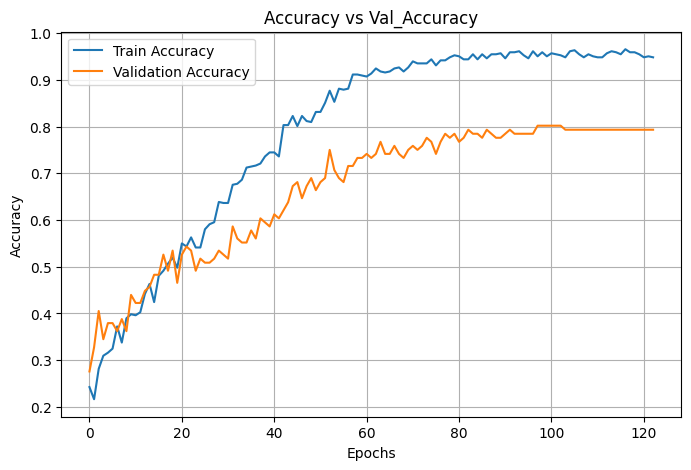

In [17]:
# Graficar accuracy de cada modelo
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Accuracy vs Val_Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# Predicciones individuales de cada modelo
preds = model.predict(X_test)
final_preds = np.argmax(preds, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step


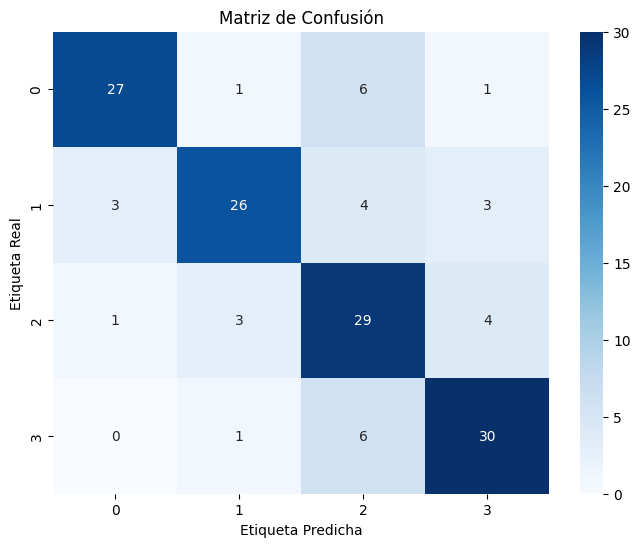

In [29]:
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()

In [20]:
# view classification report
print(classification_report(y_test, final_preds, digits=3))

              precision    recall  f1-score   support

           0      0.848     0.800     0.824        35
           1      0.867     0.722     0.788        36
           2      0.659     0.784     0.716        37
           3      0.789     0.811     0.800        37

    accuracy                          0.779       145
   macro avg      0.791     0.779     0.782       145
weighted avg      0.790     0.779     0.781       145



In [30]:
# Save the model
model.save('../save_model/transformer_model_77.h5')
# save the history
with open('../save_model/transformer_history_77.pkl', 'wb') as file:
    pickle.dump(history.history, file)